# **AE2**

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import List, Tuple
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle as MplRectangle

### **Helper classes**

In [ ]:
class Rectangle:
    def __init__(self, center: Tuple[float, float], width: float, height: float, value: float):
        """
        Initializes a rectangle.

        Parameters:
            center (tuple): (x, y) coordinates of the rectangle center.
            width (float): Width of the rectangle.
            height (float): Height of the rectangle.
            value (float): Associated value (e.g., profit) of the rectangle.
        """
        self.center = center
        self.width = width
        self.height = height
        self.value = value

    def inside_circle(self, radius: float) -> bool:
        """
        Checks if the entire rectangle is within a circle of given radius.

        Parameters:
            radius (float): Radius of the enclosing circle.

        Returns:
            bool: True if all corners are within the circle, False otherwise.
        """
        x, y = self.center
        corners = self.get_bounds()
        for corner_x in [corners[0], corners[2]]:
            for corner_y in [corners[1], corners[3]]:
                if corner_x**2 + corner_y**2 > radius**2:
                    return False
        return True

    def get_bounds(self):
        """
        Returns the bounding box of the rectangle.

        Returns:
            tuple: (x_min, y_min, x_max, y_max) coordinates.
        """
        x, y = self.center
        return (x - self.width / 2, y - self.height / 2, x + self.width / 2, y + self.height / 2)

    def overlaps_with(self, other: 'Rectangle') -> bool:
        """
        Checks if this rectangle overlaps with another rectangle.

        Parameters:
            other (Rectangle): Another rectangle.

        Returns:
            bool: True if overlapping, False otherwise.
        """
        ax1, ay1, ax2, ay2 = self.get_bounds()
        bx1, by1, bx2, by2 = other.get_bounds()
        return not (ax2 <= bx1 or ax1 >= bx2 or ay2 <= by1 or ay1 >= by2)

class Individual:
    def __init__(self, radius: float, available_rectangles: List[Tuple[float, float, float]]):
        """
        Initializes an individual solution.

        Parameters:
            radius (float): Radius of the enclosing circle.
            available_rectangles (list): List of tuples (width, height, value).
        """
        self.radius = radius
        self.available_rectangles = available_rectangles
        self.rectangles: List[Rectangle] = []

    def clone(self) -> 'Individual':
        """
        Creates a deep copy of the individual.

        Returns:
            Individual: Cloned individual.
        """
        clone = Individual(self.radius, self.available_rectangles)
        clone.rectangles = [Rectangle(r.center, r.width, r.height, r.value) for r in self.rectangles]
        return clone

    def total_value(self) -> float:
        """
        Calculates the total value of rectangles in the individual.

        Returns:
            float: Sum of values.
        """
        return sum(r.value for r in self.rectangles)

    def is_valid_placement(self, rect: Rectangle) -> bool:
        """
        Checks if the rectangle can be placed without overlap and inside the circle.

        Parameters:
            rect (Rectangle): Rectangle to validate.

        Returns:
            bool: True if valid placement, False otherwise.
        """
        return rect.inside_circle(self.radius) and not any(rect.overlaps_with(r) for r in self.rectangles)

    def add_random_rectangle(self, max_attempts: int = 1000) -> bool:
        """
        Attempts to add a random rectangle inside the circle without overlap.

        Parameters:
            max_attempts (int): Number of placement attempts.

        Returns:
            bool: True if a rectangle was successfully added, False otherwise.
        """
        for _ in range(max_attempts):
            w, h, v = random.choice(self.available_rectangles)
            x, y = random.uniform(-self.radius, self.radius), random.uniform(-self.radius, self.radius)
            rect = Rectangle((x, y), w, h, v)
            if self.is_valid_placement(rect):
                self.rectangles.append(rect)
                return True
        return False

    def mutate(self):
        """
        Applies mutation to the individual using various mutation strategies:
        - add: adds new random rectangles
        - move_skip: tries moving rectangles, keeps old if overlap
        - move_remove: tries moving rectangles, discards if overlap
        - replace: tries to replace with a new one
        - slide: slides rectangle diagonally while valid
        """
        mode = random.choices(['move_skip', 'move_remove', 'replace', 'slide', 'add'], 
                              [0.25, 0.25, 0.2, 0.2, 0.1])[0]
        if mode == 'add':
            for _ in range(10):
                self.add_random_rectangle()
            return

        new_rectangles = []
        for i, rect in enumerate(self.rectangles):
            dx, dy = random.gauss(0, 5), random.gauss(0, 5)
            new_center = (rect.center[0] + dx, rect.center[1] + dy)
            new_rect = Rectangle(new_center, rect.width, rect.height, rect.value)

            if not new_rect.inside_circle(self.radius):
                new_rectangles.append(rect)
                continue

            others = new_rectangles + self.rectangles[i+1:]

            if mode == 'move_skip':
                if not any(new_rect.overlaps_with(r) for r in others):
                    new_rectangles.append(new_rect)
                else:
                    new_rectangles.append(rect)

            elif mode == 'move_remove':
                if not any(new_rect.overlaps_with(r) for r in others):
                    new_rectangles.append(new_rect)

            elif mode == 'replace':
                if self.add_random_rectangle():
                    continue  
                else:
                    new_rectangles.append(rect)

            elif mode == 'slide':
                temp = new_rect
                last_valid = rect
                step = 1.0
                while temp.inside_circle(self.radius) and not any(temp.overlaps_with(r) for r in others):
                    last_valid = temp
                    next_center = (temp.center[0] + step, temp.center[1] + step)
                    temp = Rectangle(next_center, temp.width, temp.height, temp.value)
                new_rectangles.append(last_valid)

        self.rectangles = new_rectangles

    def crossover(self, other: 'Individual') -> Tuple['Individual', 'Individual']:
        """
        Performs geometric crossover by splitting along a random axis.

        Parameters:
            other (Individual): Another individual to crossover with.

        Returns:
            tuple: Two new offspring individuals.
        """
        axis = random.choice(['x', 'y'])
        cut = random.uniform(-self.radius, self.radius)
        child1 = Individual(self.radius, self.available_rectangles)
        child2 = Individual(self.radius, self.available_rectangles)

        def add_filtered(source, target, direction):
            for rect in source.rectangles:
                coord = rect.center[0] if axis == 'x' else rect.center[1]
                if (coord < cut and direction == 'left') or (coord >= cut and direction == 'right'):
                    new_rect = Rectangle(rect.center, rect.width, rect.height, rect.value)
                    if target.is_valid_placement(new_rect):
                        target.rectangles.append(new_rect)

        add_filtered(self, child1, 'left')
        add_filtered(other, child1, 'right')
        add_filtered(other, child2, 'left')
        add_filtered(self, child2, 'right')

        return child1, child2


### **Genetic Algorithm**

In [ ]:
class GeneticAlgorithm:
    def __init__(
        self,
        radius: float,
        available_rectangles: List[Tuple[float, float, float]],
        population_size: int = 50,
        generations: int = 100,
        elitism_rate: float = 0.1,
        mutation_rate: float = 0.7,
        crossover_rate: float = 0.9):
        """
        Initializes the genetic algorithm for the rectangle packing problem.

        Parameters:
            radius (float): Radius of the circular container.
            available_rectangles (List[Tuple[float, float, float]]): List of available rectangle types (width, height, value).
            population_size (int): Number of individuals in each generation.
            generations (int): Number of generations to evolve.
            elitism_rate (float): Fraction of top individuals preserved unchanged in next generation.
            mutation_rate (float): Probability of mutating an individual.
            crossover_rate (float): Probability of performing crossover between individuals.
        """
        self.radius = radius
        self.available_rectangles = available_rectangles
        self.population_size = population_size
        self.generations = generations
        self.elitism_count = int(elitism_rate * population_size)
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.population: List[Individual] = []
        self.best_individual: Individual = None
        self.best_fitness_history = []

    def initialize_population(self):
        """
        Initializes the initial population with random rectangle placements.
        Each individual attempts to place 100 rectangles randomly inside the circle.
        """
        self.population = []
        for _ in range(self.population_size):
            individual = Individual(self.radius, self.available_rectangles)
            for _ in range(100):
                individual.add_random_rectangle()
            self.population.append(individual)

    def evaluate_fitness(self) -> List[float]:
        """
        Calculates the fitness of each individual in the population.

        Returns:
            List[float]: Total values of rectangles placed by each individual.
        """
        return [ind.total_value() for ind in self.population]

    def select_parents(self, fitnesses: List[float]) -> List[Individual]:
        """
        Selects individuals to be used as parents using softmax-proportional selection.

        Parameters:
            fitnesses (List[float]): Fitness values for current population.

        Returns:
            List[Individual]: Selected parents (cloned).
        """
        exp_fit = np.exp(fitnesses - np.max(fitnesses))
        probs = exp_fit / np.sum(exp_fit)
        selected_indices = np.random.choice(range(self.population_size),
                                            size=self.population_size - self.elitism_count,
                                            p=probs)
        return [self.population[i].clone() for i in selected_indices]

    def evolve(self, verbose: bool = True):
        """
        Executes the evolutionary process over a defined number of generations.

        Parameters:
            verbose (bool): Whether to print progress after each generation.
        """
        self.initialize_population()
        for gen in range(self.generations):
            fitnesses = self.evaluate_fitness()
            best_idx = np.argmax(fitnesses)
            best_fitness = fitnesses[best_idx]
            self.best_fitness_history.append(best_fitness)

            if self.best_individual is None or best_fitness > self.best_individual.total_value():
                self.best_individual = self.population[best_idx].clone()

            if verbose:
                print(f"Generation {gen + 1}: Best Fitness = {best_fitness:.2f}")

            sorted_indices = np.argsort(fitnesses)[::-1]
            new_population = [self.population[i].clone() for i in sorted_indices[:self.elitism_count]]
            parents = self.select_parents(fitnesses)
            random.shuffle(parents)

            while len(new_population) < self.population_size:
                if random.random() < self.crossover_rate and len(parents) >= 2:
                    p1 = parents.pop()
                    p2 = parents.pop()
                    c1, c2 = p1.crossover(p2)
                    new_population.extend([c1, c2])
                elif parents:
                    new_population.append(parents.pop())
                else:
                    new_population.append(Individual(self.radius, self.available_rectangles))

            self.population = new_population[:self.population_size]

            for individual in self.population[self.elitism_count:]:
                if random.random() < self.mutation_rate:
                    individual.mutate()

    def get_best_individual(self) -> Individual:
        """
        Returns the best individual found during the evolution process.

        Returns:
            Individual: Best solution found.
        """
        return self.best_individual

    def plot_summary(self, best_individual: Individual):
        """
        Visualizes the best individual and the evolution of fitness over generations.

        Parameters:
            best_individual (Individual): Best solution to display.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        fig.suptitle("Genetic Algorithm Summary", fontsize=16)

        # --- Plot 1: Best individual rectangles ---
        ind = best_individual
        ax1.set_aspect('equal')
        circle = plt.Circle((0, 0), ind.radius, color='lightblue', alpha=0.5)
        ax1.add_patch(circle)

        for rect in ind.rectangles:
            x1, y1, x2, y2 = rect.get_bounds()
            mpl_rect = MplRectangle((x1, y1), rect.width, rect.height,
                                    edgecolor='black', facecolor='green', alpha=0.6)
            ax1.add_patch(mpl_rect)

            ax1.text(rect.center[0], rect.center[1], f"{rect.value:.1f}",
                    ha='center', va='center', fontsize=8, color='black')

        buffer = 0.1 * ind.radius  
        ax1.set_xlim(-ind.radius - buffer, ind.radius + buffer)
        ax1.set_ylim(-ind.radius - buffer, ind.radius + buffer)
        ax1.set_title(f"Best Individual\nTotal Value: {ind.total_value():.2f}")
        ax1.grid(False)

        # --- Plot 2: Fitness over generations ---
        ax2.plot(self.best_fitness_history, marker='o', linewidth=2, color='blue')
        ax2.set_title("Fitness Over Generations")
        ax2.set_xlabel("Generation")
        ax2.set_ylabel("Best Fitness")
        ax2.grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

### **Tests**

### **r800 dataset** - minimum 30000 score

Generation 1: Best Fitness = 17940.00
Generation 2: Best Fitness = 17940.00
Generation 3: Best Fitness = 17940.00
Generation 4: Best Fitness = 17940.00
Generation 5: Best Fitness = 18380.00
Generation 6: Best Fitness = 18380.00
Generation 7: Best Fitness = 18440.00
Generation 8: Best Fitness = 20080.00
Generation 9: Best Fitness = 20480.00
Generation 10: Best Fitness = 21200.00
Generation 11: Best Fitness = 21200.00
Generation 12: Best Fitness = 22040.00
Generation 13: Best Fitness = 22040.00
Generation 14: Best Fitness = 22040.00
Generation 15: Best Fitness = 22040.00
Generation 16: Best Fitness = 22040.00
Generation 17: Best Fitness = 22200.00
Generation 18: Best Fitness = 22740.00
Generation 19: Best Fitness = 22740.00
Generation 20: Best Fitness = 22740.00
Generation 21: Best Fitness = 23540.00
Generation 22: Best Fitness = 23540.00
Generation 23: Best Fitness = 24140.00
Generation 24: Best Fitness = 24140.00
Generation 25: Best Fitness = 24140.00
Generation 26: Best Fitness = 2414

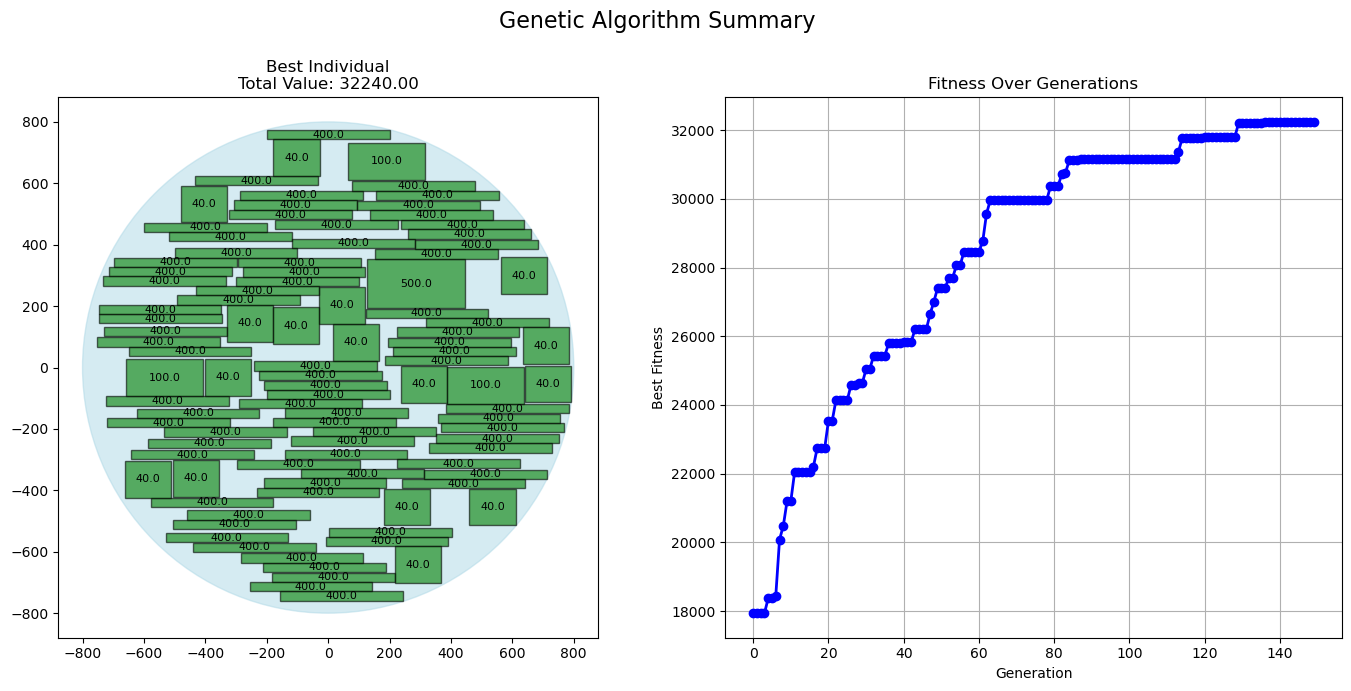

In [100]:
data = pd.read_csv("data/r800.csv", header=None).values
rects = [(w, h, val) for w, h, val in data]

ga = GeneticAlgorithm(radius=800, 
                      available_rectangles=rects, 
                      generations=150,
                      population_size=10,
                      mutation_rate=0.9,
                      elitism_rate = 0.3,
                      crossover_rate = 0.9)
ga.evolve()

best = ga.get_best_individual()
ga.plot_summary(best)

### **r1200 dataset** - minimum 30000 score

In [104]:
data = pd.read_csv("data/r1200.csv", header=None).values
rects = [(w, h, val) for w, h, val in data]

ga = GeneticAlgorithm(radius=1200, 
                      available_rectangles=rects, 
                      generations=150,
                      population_size=100,
                      mutation_rate=0.9,
                      elitism_rate = 0.3,
                      crossover_rate = 0.9)
ga.evolve()

best = ga.get_best_individual()
ga.plot_summary(best)

Generation 1: Best Fitness = 19440.00
Generation 2: Best Fitness = 20100.00
Generation 3: Best Fitness = 20540.00
Generation 4: Best Fitness = 20900.00
Generation 5: Best Fitness = 20980.00
Generation 6: Best Fitness = 21060.00


KeyboardInterrupt: 

### **r1000 dataset** - minimum 17500 score

In [ ]:
data = pd.read_csv("data/r1000.csv", header=None).values
rects = [(w, h, val) for w, h, val in data]

ga = GeneticAlgorithm(radius=1000, 
                      available_rectangles=rects, 
                      generations=150,
                      population_size=10,
                      mutation_rate=0.9,
                      elitism_rate = 0.3,
                      crossover_rate = 0.9)
ga.evolve()

best = ga.get_best_individual()
ga.plot_summary(best)

### **r1100** - minimum 25000 score

In [101]:
data = pd.read_csv("data/r1100.csv", header=None).values
rects = [(w, h, val) for w, h, val in data]

ga = GeneticAlgorithm(radius=1100, 
                      available_rectangles=rects, 
                      generations=150,
                      population_size=10,
                      mutation_rate=0.9,
                      elitism_rate = 0.3,
                      crossover_rate = 0.9)
ga.evolve()

best = ga.get_best_individual()
ga.plot_summary(best)

Generation 1: Best Fitness = 15860.00
Generation 2: Best Fitness = 15860.00
Generation 3: Best Fitness = 15940.00
Generation 4: Best Fitness = 15940.00
Generation 5: Best Fitness = 16080.00
Generation 6: Best Fitness = 16120.00
Generation 7: Best Fitness = 16120.00
Generation 8: Best Fitness = 16120.00
Generation 9: Best Fitness = 16120.00
Generation 10: Best Fitness = 16160.00
Generation 11: Best Fitness = 16160.00
Generation 12: Best Fitness = 16160.00
Generation 13: Best Fitness = 16160.00
Generation 14: Best Fitness = 16160.00
Generation 15: Best Fitness = 16280.00
Generation 16: Best Fitness = 16320.00
Generation 17: Best Fitness = 16320.00
Generation 18: Best Fitness = 16320.00
Generation 19: Best Fitness = 16320.00
Generation 20: Best Fitness = 16420.00
Generation 21: Best Fitness = 16420.00
Generation 22: Best Fitness = 16460.00
Generation 23: Best Fitness = 16460.00
Generation 24: Best Fitness = 16460.00
Generation 25: Best Fitness = 16460.00
Generation 26: Best Fitness = 1646

KeyboardInterrupt: 

### **r850**

In [ ]:
data = pd.read_csv("data/r850.csv", header=None).values
rects = [(w, h, val) for w, h, val in data]

ga = GeneticAlgorithm(radius=850, 
                      available_rectangles=rects, 
                      generations=150,
                      population_size=10,
                      mutation_rate=0.9,
                      elitism_rate = 0.3,
                      crossover_rate = 0.9)
ga.evolve()

best = ga.get_best_individual()
ga.plot_summary(best)